In [1]:
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import precision_score,f1_score,recall_score,classification_report,accuracy_score
import joblib
from imblearn.over_sampling import SMOTE
from tqdm import tqdm

In [2]:
data_tst=pd.read_csv(r"C:\Users\navee\OneDrive\Desktop\Microsoft cybersecurity\GUIDE_Test.csv")

C:\Users\navee\AppData\Local\Temp\ipykernel_31336\2977310459.py:1: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  data_tst=pd.read_csv(r"C:\Users\navee\OneDrive\Desktop\Microsoft cybersecurity\GUIDE_Test.csv")


In [3]:
data_tst.head()

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City,Usage
0,1245540519230,657,11767,87199,2024-06-04T22:56:27.000Z,524,563,LateralMovement,T1021;T1047;T1105;T1569.002,BenignPositive,...,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630,Private
1,1400159342154,3,91158,632273,2024-06-03T12:58:26.000Z,2,2,CommandAndControl,NaN,BenignPositive,...,NaN,0,0,NaN,Suspicious,Suspicious,242,1445,10630,Public
2,1279900255923,145,32247,131719,2024-06-08T03:20:49.000Z,2932,10807,LateralMovement,T1021;T1027.002;T1027.005;T1105,BenignPositive,...,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630,Public
3,60129547292,222,15294,917686,2024-06-12T12:07:31.000Z,0,0,InitialAccess,T1078;T1078.004,FalsePositive,...,NaN,5,66,NaN,NaN,NaN,242,1445,10630,Public
4,515396080539,363,7615,5944,2024-06-06T17:42:05.000Z,27,18,Discovery,T1087;T1087.002,BenignPositive,...,Suspicious,5,66,NaN,NaN,NaN,242,1445,10630,Public


In [4]:
list(data_tst.columns)

['Id',
 'OrgId',
 'IncidentId',
 'AlertId',
 'Timestamp',
 'DetectorId',
 'AlertTitle',
 'Category',
 'MitreTechniques',
 'IncidentGrade',
 'ActionGrouped',
 'ActionGranular',
 'EntityType',
 'EvidenceRole',
 'DeviceId',
 'Sha256',
 'IpAddress',
 'Url',
 'AccountSid',
 'AccountUpn',
 'AccountObjectId',
 'AccountName',
 'DeviceName',
 'NetworkMessageId',
 'EmailClusterId',
 'RegistryKey',
 'RegistryValueName',
 'RegistryValueData',
 'ApplicationId',
 'ApplicationName',
 'OAuthApplicationId',
 'ThreatFamily',
 'FileName',
 'FolderPath',
 'ResourceIdName',
 'ResourceType',
 'Roles',
 'OSFamily',
 'OSVersion',
 'AntispamDirection',
 'SuspicionLevel',
 'LastVerdict',
 'CountryCode',
 'State',
 'City',
 'Usage']

In [5]:
pd.set_option('display.max_columns', None)
data_tst.head(1)

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,ActionGrouped,ActionGranular,EntityType,EvidenceRole,DeviceId,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,EmailClusterId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName,OAuthApplicationId,ThreatFamily,FileName,FolderPath,ResourceIdName,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City,Usage
0,1245540519230,657,11767,87199,2024-06-04T22:56:27.000Z,524,563,LateralMovement,T1021;T1047;T1105;T1569.002,BenignPositive,NaN,NaN,User,Impacted,98799,138268,360606,160396,2610,3699,425863,863,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630,Private


In [6]:
data_tst.shape

(4147992, 46)

In [7]:
data_tst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4147992 entries, 0 to 4147991
Data columns (total 46 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Id                  int64  
 1   OrgId               int64  
 2   IncidentId          int64  
 3   AlertId             int64  
 4   Timestamp           object 
 5   DetectorId          int64  
 6   AlertTitle          int64  
 7   Category            object 
 8   MitreTechniques     object 
 9   IncidentGrade       object 
 10  ActionGrouped       object 
 11  ActionGranular      object 
 12  EntityType          object 
 13  EvidenceRole        object 
 14  DeviceId            int64  
 15  Sha256              int64  
 16  IpAddress           int64  
 17  Url                 int64  
 18  AccountSid          int64  
 19  AccountUpn          int64  
 20  AccountObjectId     int64  
 21  AccountName         int64  
 22  DeviceName          int64  
 23  NetworkMessageId    int64  
 24  EmailClusterId      floa

In [8]:
threshold= len(data_tst)* 0.5  
data_tst=data_tst.dropna(thresh=threshold,axis=1)

In [9]:
data_tst.shape

(4147992, 36)

In [10]:
data_tst.duplicated().sum()

np.int64(225297)

In [11]:
data_tst.drop_duplicates(inplace=True)

In [13]:
data_tst

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,DeviceId,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City,Usage
0,1245540519230,657,11767,87199,2024-06-04T22:56:27.000Z,524,563,LateralMovement,BenignPositive,User,Impacted,98799,138268,360606,160396,2610,3699,425863,863,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630,Private
1,1400159342154,3,91158,632273,2024-06-03T12:58:26.000Z,2,2,CommandAndControl,BenignPositive,Machine,Impacted,1239,138268,360606,160396,441377,673934,425863,453297,2833,529644,1631,635,860,2251,3421,881,289573,117668,3586,0,0,242,1445,10630,Public
2,1279900255923,145,32247,131719,2024-06-08T03:20:49.000Z,2932,10807,LateralMovement,BenignPositive,Process,Related,98799,4296,360606,160396,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,14,22,3586,5,66,242,1445,10630,Public
3,60129547292,222,15294,917686,2024-06-12T12:07:31.000Z,0,0,InitialAccess,FalsePositive,CloudLogonSession,Related,98799,138268,360606,160396,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630,Public
4,515396080539,363,7615,5944,2024-06-06T17:42:05.000Z,27,18,Discovery,BenignPositive,User,Impacted,98799,138268,360606,160396,133549,673934,425863,136104,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630,Public
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4147985,171798692464,42,391,638112,2024-06-03T20:24:41.000Z,135,7322,Malware,BenignPositive,Machine,Impacted,4,138268,360606,160396,441377,673934,425863,453297,4,529644,1631,635,860,2251,3421,881,289573,117668,3586,0,0,242,1445,10630,Public
4147987,541165881145,262,3017,227156,2024-06-04T03:53:15.000Z,139,120,InitialAccess,BenignPositive,User,Impacted,98799,138268,360606,160396,13354,13012,13489,14567,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630,Public
4147988,438086666953,1323,31001,304819,2024-06-04T19:32:19.000Z,219,196,InitialAccess,BenignPositive,User,Impacted,98799,138268,360606,160396,95744,172717,96809,107151,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630,Private
4147989,1297080124487,47,3653,7243,2024-06-15T00:50:22.000Z,57,29,CommandAndControl,FalsePositive,Ip,Related,98799,138268,1084,160396,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630,Public


In [14]:
data_tst.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3922695 entries, 0 to 4147990
Data columns (total 36 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   Id                  int64 
 1   OrgId               int64 
 2   IncidentId          int64 
 3   AlertId             int64 
 4   Timestamp           object
 5   DetectorId          int64 
 6   AlertTitle          int64 
 7   Category            object
 8   IncidentGrade       object
 9   EntityType          object
 10  EvidenceRole        object
 11  DeviceId            int64 
 12  Sha256              int64 
 13  IpAddress           int64 
 14  Url                 int64 
 15  AccountSid          int64 
 16  AccountUpn          int64 
 17  AccountObjectId     int64 
 18  AccountName         int64 
 19  DeviceName          int64 
 20  NetworkMessageId    int64 
 21  RegistryKey         int64 
 22  RegistryValueName   int64 
 23  RegistryValueData   int64 
 24  ApplicationId       int64 
 25  ApplicationName     int

In [15]:
data_tst["IncidentGrade"].fillna(data_tst["IncidentGrade"].mode()[0],inplace=True)

C:\Users\navee\AppData\Local\Temp\ipykernel_31336\2053879862.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_tst["IncidentGrade"].fillna(data_tst["IncidentGrade"].mode()[0],inplace=True)


In [16]:
data_tst['Timestamp']=pd.to_datetime(data_tst['Timestamp'])

In [17]:
data_tst['Timestamp'].head()

0   2024-06-04 22:56:27+00:00
1   2024-06-03 12:58:26+00:00
2   2024-06-08 03:20:49+00:00
3   2024-06-12 12:07:31+00:00
4   2024-06-06 17:42:05+00:00
Name: Timestamp, dtype: datetime64[ns, UTC]

In [18]:
data_tst["Day"]=data_tst["Timestamp"].dt.day
data_tst["Month"]=data_tst["Timestamp"].dt.month
data_tst["Year"]=data_tst["Timestamp"].dt.year
data_tst["Hour"]=data_tst["Timestamp"].dt.hour
data_tst["Time"]=data_tst["Timestamp"].dt.time

In [19]:
[features for features in data_tst.columns if data_tst[features].isnull().sum()>0]

[]

In [20]:
data_tst.drop("Timestamp",axis=1,inplace=True)  
print(data_tst.head())

              Id  OrgId  IncidentId  AlertId  DetectorId  AlertTitle  \
0  1245540519230    657       11767    87199         524         563   
1  1400159342154      3       91158   632273           2           2   
2  1279900255923    145       32247   131719        2932       10807   
3    60129547292    222       15294   917686           0           0   
4   515396080539    363        7615     5944          27          18   

            Category   IncidentGrade         EntityType EvidenceRole  \
0    LateralMovement  BenignPositive               User     Impacted   
1  CommandAndControl  BenignPositive            Machine     Impacted   
2    LateralMovement  BenignPositive            Process      Related   
3      InitialAccess   FalsePositive  CloudLogonSession      Related   
4          Discovery  BenignPositive               User     Impacted   

   DeviceId  Sha256  IpAddress     Url  AccountSid  AccountUpn  \
0     98799  138268     360606  160396        2610        3699   
1 

In [21]:
pd.set_option("display.max_columns", None)
data_tst.head()

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,DeviceId,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City,Usage,Day,Month,Year,Hour,Time
0,1245540519230,657,11767,87199,524,563,LateralMovement,BenignPositive,User,Impacted,98799,138268,360606,160396,2610,3699,425863,863,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630,Private,4,6,2024,22,22:56:27
1,1400159342154,3,91158,632273,2,2,CommandAndControl,BenignPositive,Machine,Impacted,1239,138268,360606,160396,441377,673934,425863,453297,2833,529644,1631,635,860,2251,3421,881,289573,117668,3586,0,0,242,1445,10630,Public,3,6,2024,12,12:58:26
2,1279900255923,145,32247,131719,2932,10807,LateralMovement,BenignPositive,Process,Related,98799,4296,360606,160396,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,14,22,3586,5,66,242,1445,10630,Public,8,6,2024,3,03:20:49
3,60129547292,222,15294,917686,0,0,InitialAccess,FalsePositive,CloudLogonSession,Related,98799,138268,360606,160396,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630,Public,12,6,2024,12,12:07:31
4,515396080539,363,7615,5944,27,18,Discovery,BenignPositive,User,Impacted,98799,138268,360606,160396,133549,673934,425863,136104,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630,Public,6,6,2024,17,17:42:05


In [22]:
data_tst['IncidentGrade'].value_counts()

IncidentGrade
BenignPositive    1630942
TruePositive      1422856
FalsePositive      868897
Name: count, dtype: int64

In [23]:
data_tst.IncidentGrade.unique()

array(['BenignPositive', 'FalsePositive', 'TruePositive'], dtype=object)

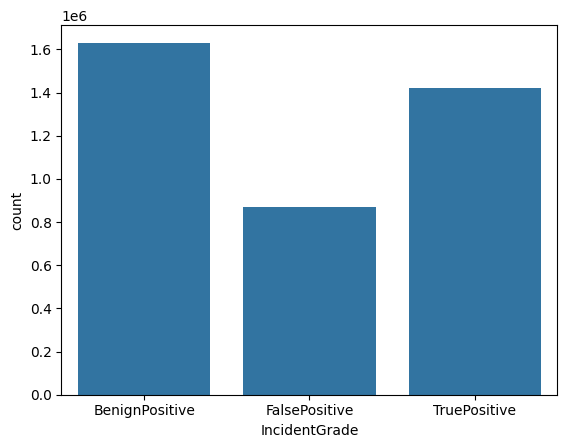

In [24]:
sns.countplot(x="IncidentGrade", data=data_tst)
plt.show()

In [25]:
day_incident_grade = data_tst.groupby(['Day', 'IncidentGrade']).size().unstack()

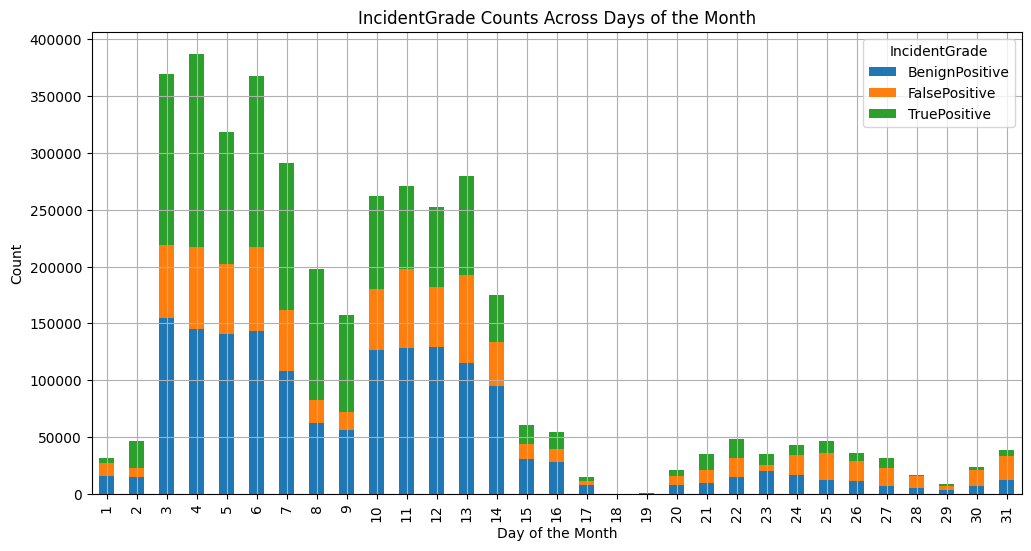

In [26]:
day_incident_grade.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.xlabel('Day of the Month')
plt.ylabel('Count')
plt.title('IncidentGrade Counts Across Days of the Month')
plt.legend(title='IncidentGrade')
plt.grid(True)
plt.show()

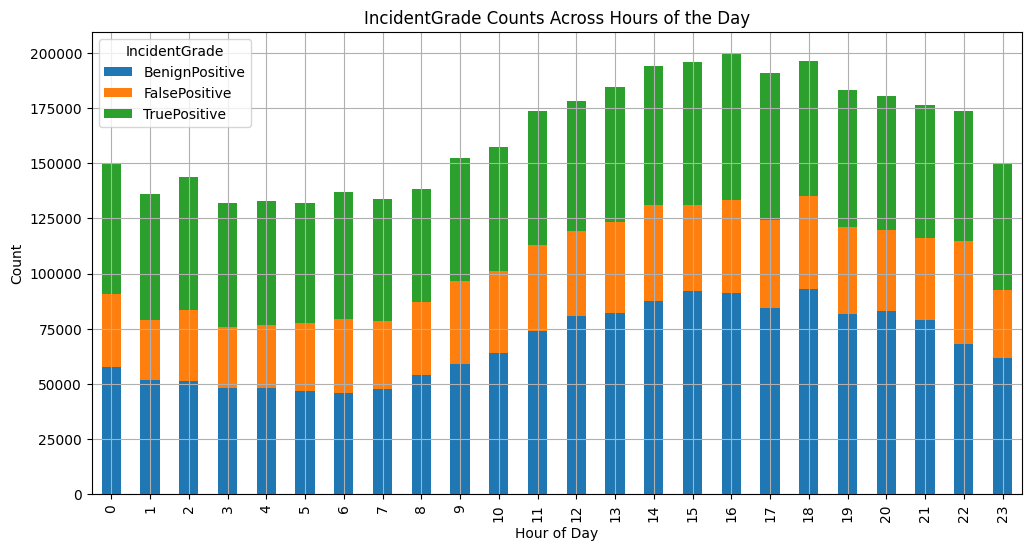

In [27]:
hour_incident =data_tst.groupby(['Hour', 'IncidentGrade']).size().unstack()

hour_incident.plot(kind='bar', stacked=True, figsize=(12,6))
plt.xlabel("Hour of Day")
plt.ylabel('Count')
plt.title('IncidentGrade Counts Across Hours of the Day')
plt.legend(title="IncidentGrade")
plt.grid(True)
plt.show()

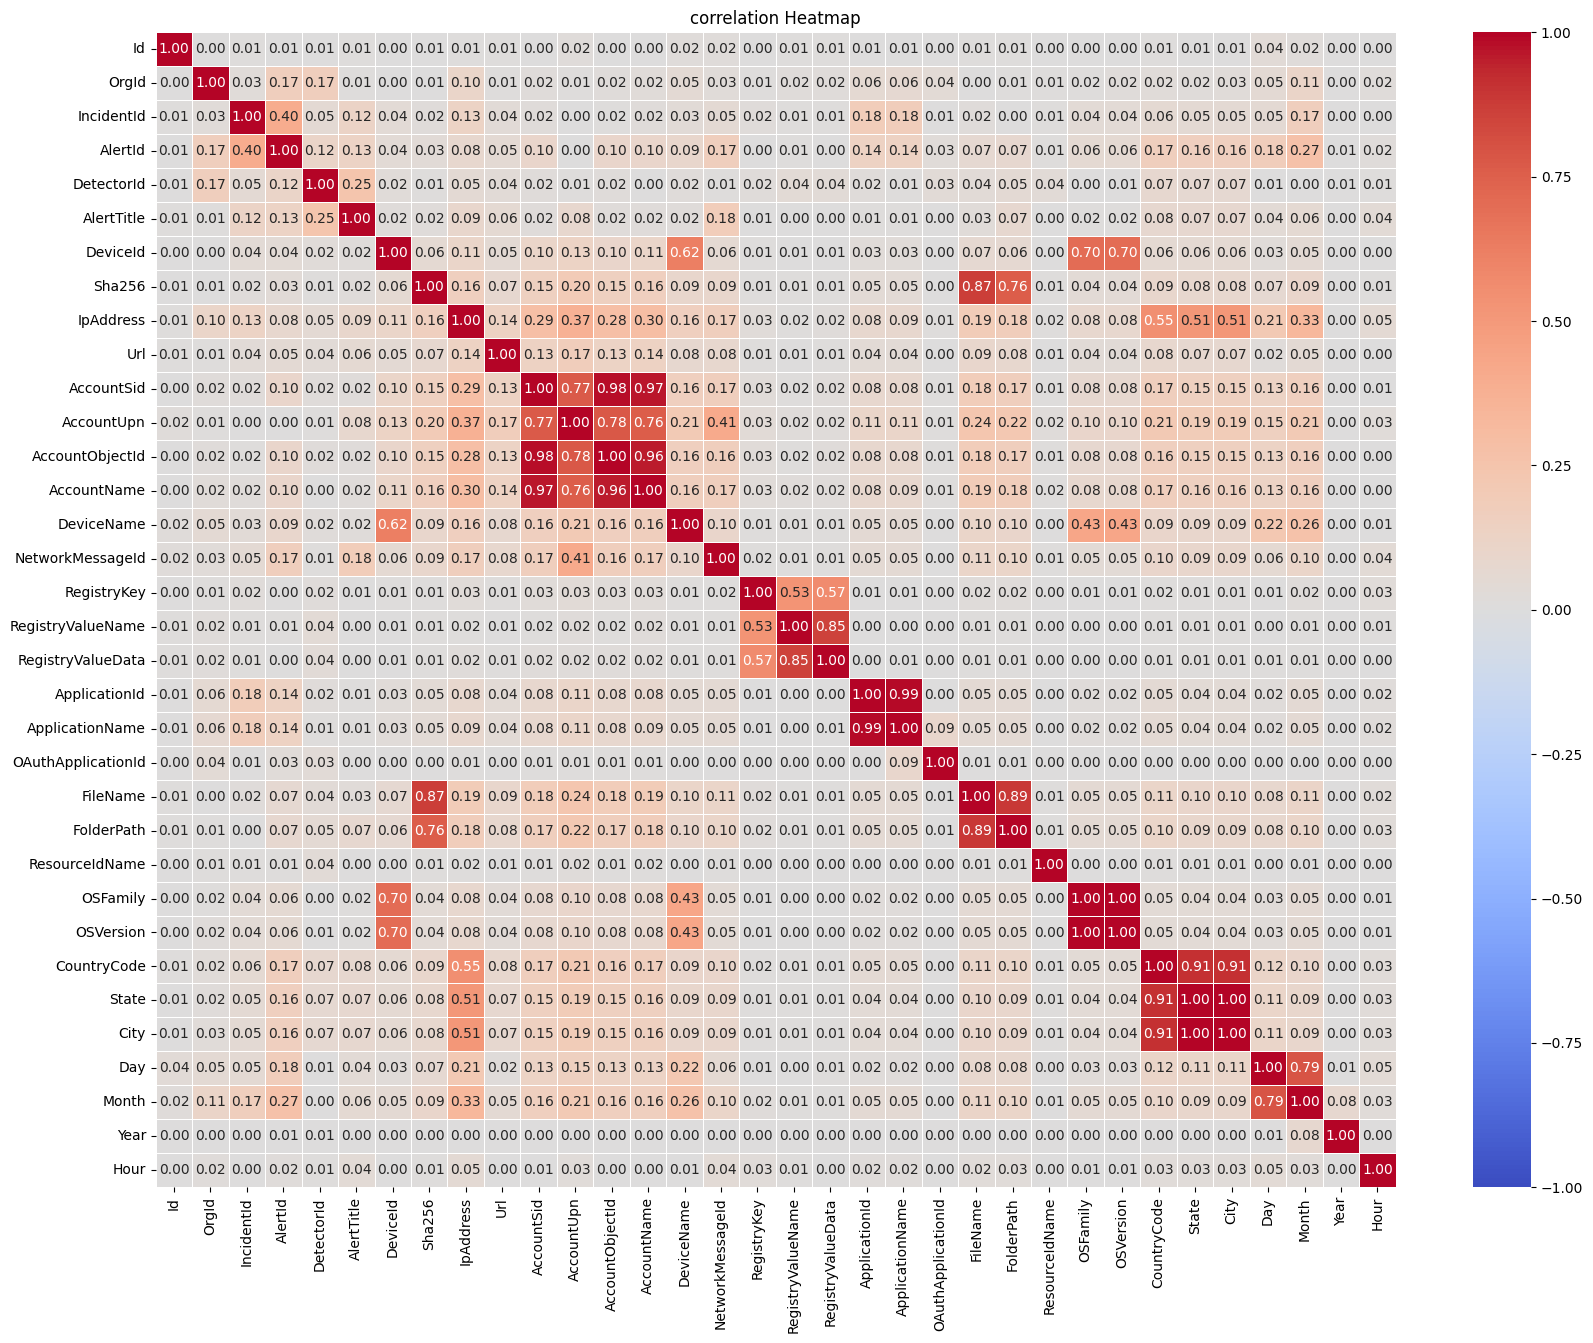

In [28]:
numeric_df=data_tst.select_dtypes(include=['number'])

corr_matrix= numeric_df.corr().abs()

plt.figure(figsize=(20,15))
sns.heatmap(corr_matrix,annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, linewidths=0.5)
plt.title('correlation Heatmap')
plt.show()

In [29]:
data_tst.drop(["CountryCode","Sha256","ApplicationName","RegistryValueName","AccountSid","OSFamily","OSVersion","AccountObjectId","State","FolderPath","AccountUpn"], axis =1 , inplace = True)

In [30]:
data_tst

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,DeviceId,IpAddress,Url,AccountName,DeviceName,NetworkMessageId,RegistryKey,RegistryValueData,ApplicationId,OAuthApplicationId,FileName,ResourceIdName,City,Usage,Day,Month,Year,Hour,Time
0,1245540519230,657,11767,87199,524,563,LateralMovement,BenignPositive,User,Impacted,98799,360606,160396,863,153085,529644,1631,860,2251,881,289573,3586,10630,Private,4,6,2024,22,22:56:27
1,1400159342154,3,91158,632273,2,2,CommandAndControl,BenignPositive,Machine,Impacted,1239,360606,160396,453297,2833,529644,1631,860,2251,881,289573,3586,10630,Public,3,6,2024,12,12:58:26
2,1279900255923,145,32247,131719,2932,10807,LateralMovement,BenignPositive,Process,Related,98799,360606,160396,453297,153085,529644,1631,860,2251,881,14,3586,10630,Public,8,6,2024,3,03:20:49
3,60129547292,222,15294,917686,0,0,InitialAccess,FalsePositive,CloudLogonSession,Related,98799,360606,160396,453297,153085,529644,1631,860,2251,881,289573,3586,10630,Public,12,6,2024,12,12:07:31
4,515396080539,363,7615,5944,27,18,Discovery,BenignPositive,User,Impacted,98799,360606,160396,136104,153085,529644,1631,860,2251,881,289573,3586,10630,Public,6,6,2024,17,17:42:05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4147985,171798692464,42,391,638112,135,7322,Malware,BenignPositive,Machine,Impacted,4,360606,160396,453297,4,529644,1631,860,2251,881,289573,3586,10630,Public,3,6,2024,20,20:24:41
4147987,541165881145,262,3017,227156,139,120,InitialAccess,BenignPositive,User,Impacted,98799,360606,160396,14567,153085,529644,1631,860,2251,881,289573,3586,10630,Public,4,6,2024,3,03:53:15
4147988,438086666953,1323,31001,304819,219,196,InitialAccess,BenignPositive,User,Impacted,98799,360606,160396,107151,153085,529644,1631,860,2251,881,289573,3586,10630,Private,4,6,2024,19,19:32:19
4147989,1297080124487,47,3653,7243,57,29,CommandAndControl,FalsePositive,Ip,Related,98799,1084,160396,453297,153085,529644,1631,860,2251,881,289573,3586,10630,Public,15,6,2024,0,00:50:22


In [31]:
data_tst.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3922695 entries, 0 to 4147990
Data columns (total 29 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   Id                  int64 
 1   OrgId               int64 
 2   IncidentId          int64 
 3   AlertId             int64 
 4   DetectorId          int64 
 5   AlertTitle          int64 
 6   Category            object
 7   IncidentGrade       object
 8   EntityType          object
 9   EvidenceRole        object
 10  DeviceId            int64 
 11  IpAddress           int64 
 12  Url                 int64 
 13  AccountName         int64 
 14  DeviceName          int64 
 15  NetworkMessageId    int64 
 16  RegistryKey         int64 
 17  RegistryValueData   int64 
 18  ApplicationId       int64 
 19  OAuthApplicationId  int64 
 20  FileName            int64 
 21  ResourceIdName      int64 
 22  City                int64 
 23  Usage               object
 24  Day                 int32 
 25  Month               int

In [32]:
data_tst.select_dtypes(include=["object"]).columns

Index(['Category', 'IncidentGrade', 'EntityType', 'EvidenceRole', 'Usage',
       'Time'],
      dtype='object')

In [33]:
Categorical_colts=['Category', 'IncidentGrade', 'EntityType', 'EvidenceRole', 'Usage',
       'Time']

In [34]:
encoders = {}
for i in Categorical_colts:
    le = LabelEncoder()
    data_tst[i]=le.fit_transform(data_tst[i])
    encoders[i]=le

In [35]:
data_tst

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,DeviceId,IpAddress,Url,AccountName,DeviceName,NetworkMessageId,RegistryKey,RegistryValueData,ApplicationId,OAuthApplicationId,FileName,ResourceIdName,City,Usage,Day,Month,Year,Hour,Time
0,1245540519230,657,11767,87199,524,563,11,0,28,0,98799,360606,160396,863,153085,529644,1631,860,2251,881,289573,3586,10630,0,4,6,2024,22,82520
1,1400159342154,3,91158,632273,2,2,1,0,15,0,1239,360606,160396,453297,2833,529644,1631,860,2251,881,289573,3586,10630,1,3,6,2024,12,46649
2,1279900255923,145,32247,131719,2932,10807,11,0,23,1,98799,360606,160396,453297,153085,529644,1631,860,2251,881,14,3586,10630,1,8,6,2024,3,12037
3,60129547292,222,15294,917686,0,0,10,1,7,1,98799,360606,160396,453297,153085,529644,1631,860,2251,881,289573,3586,10630,1,12,6,2024,12,43594
4,515396080539,363,7615,5944,27,18,5,0,28,0,98799,360606,160396,136104,153085,529644,1631,860,2251,881,289573,3586,10630,1,6,6,2024,17,63665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4147985,171798692464,42,391,638112,135,7322,12,0,15,0,4,360606,160396,453297,4,529644,1631,860,2251,881,289573,3586,10630,1,3,6,2024,20,73420
4147987,541165881145,262,3017,227156,139,120,10,0,28,0,98799,360606,160396,14567,153085,529644,1631,860,2251,881,289573,3586,10630,1,4,6,2024,3,13978
4147988,438086666953,1323,31001,304819,219,196,10,0,28,0,98799,360606,160396,107151,153085,529644,1631,860,2251,881,289573,3586,10630,0,4,6,2024,19,70279
4147989,1297080124487,47,3653,7243,57,29,1,1,12,1,98799,1084,160396,453297,153085,529644,1631,860,2251,881,289573,3586,10630,1,15,6,2024,0,3020


In [36]:
data_tst.select_dtypes(include=["int32", "int64"]).columns

Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
       'Category', 'IncidentGrade', 'EntityType', 'EvidenceRole', 'DeviceId',
       'IpAddress', 'Url', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'RegistryKey', 'RegistryValueData', 'ApplicationId',
       'OAuthApplicationId', 'FileName', 'ResourceIdName', 'City', 'Usage',
       'Day', 'Month', 'Year', 'Hour', 'Time'],
      dtype='object')

In [37]:
data_tst1=data_tst.copy()

In [38]:
data_tst1.to_csv(r'C:\Users\navee\OneDrive\Desktop\Microsoft cybersecurity\Processed_Data\mtest_process.csv',index= False)

In [39]:
data_tst1.head()

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,DeviceId,IpAddress,Url,AccountName,DeviceName,NetworkMessageId,RegistryKey,RegistryValueData,ApplicationId,OAuthApplicationId,FileName,ResourceIdName,City,Usage,Day,Month,Year,Hour,Time
0,1245540519230,657,11767,87199,524,563,11,0,28,0,98799,360606,160396,863,153085,529644,1631,860,2251,881,289573,3586,10630,0,4,6,2024,22,82520
1,1400159342154,3,91158,632273,2,2,1,0,15,0,1239,360606,160396,453297,2833,529644,1631,860,2251,881,289573,3586,10630,1,3,6,2024,12,46649
2,1279900255923,145,32247,131719,2932,10807,11,0,23,1,98799,360606,160396,453297,153085,529644,1631,860,2251,881,14,3586,10630,1,8,6,2024,3,12037
3,60129547292,222,15294,917686,0,0,10,1,7,1,98799,360606,160396,453297,153085,529644,1631,860,2251,881,289573,3586,10630,1,12,6,2024,12,43594
4,515396080539,363,7615,5944,27,18,5,0,28,0,98799,360606,160396,136104,153085,529644,1631,860,2251,881,289573,3586,10630,1,6,6,2024,17,63665


In [40]:
from imblearn.over_sampling import RandomOverSampler

In [41]:
os =RandomOverSampler(random_state = 45)

In [42]:
val =data_tst1.drop('IncidentGrade', axis =1)

In [43]:
tar = data_tst1['IncidentGrade']

In [44]:
tar.value_counts()

IncidentGrade
0    1630942
2    1422856
1     868897
Name: count, dtype: int64

In [45]:
oval,otar = os.fit_resample(val,tar)

In [46]:
otar.value_counts()

IncidentGrade
0    1630942
1    1630942
2    1630942
Name: count, dtype: int64

In [47]:
fs = RandomForestClassifier(n_estimators = 300, random_state =56)

In [48]:
fs.fit(oval,otar)

RandomForestClassifier(n_estimators=300, random_state=56)

In [49]:
pd.DataFrame({
    "columns": oval.columns,
    "Score": fs.feature_importances_
}).sort_values('Score', ascending =False).head(15)["columns"].to_list()

['OrgId',
 'IncidentId',
 'DetectorId',
 'AlertId',
 'AlertTitle',
 'Category',
 'Day',
 'Id',
 'Time',
 'AccountName',
 'EntityType',
 'Hour',
 'IpAddress',
 'DeviceName',
 'City']

In [50]:
oval=oval[['OrgId',
 'IncidentId',
 'DetectorId',
 'AlertId',
 'AlertTitle',
 'Category',
 'Day',
 'Id',
 'Time',
 'AccountName',
 'EntityType',
 'Hour',
 'IpAddress',
 'DeviceName',
 'City']]

In [51]:
traindata,testdata, trainlab,testlab = train_test_split(oval,otar, test_size = 0.20, random_state = 43)

In [52]:
traindata.shape

(3914260, 15)

In [53]:
testdata.shape

(978566, 15)

In [54]:
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
import xgboost

In [55]:
dt_model= DecisionTreeClassifier(max_depth=8,random_state=100,min_samples_split=10,min_samples_leaf=5,max_features="sqrt")

In [56]:
dt_model.fit(traindata,trainlab)

DecisionTreeClassifier(max_depth=8, max_features='sqrt', min_samples_leaf=5,
                       min_samples_split=10, random_state=100)

In [57]:
def metrics(actual, predicted):
    acc = accuracy_score(actual, predicted) * 100
    prec = precision_score(actual, predicted, average="macro") * 100
    recall = recall_score(actual, predicted, average="macro") * 100
    macro_f1 = f1_score(actual, predicted, average="macro") * 100

    return pd.DataFrame({
        "Metrics": ["Accuracy", "Precision", "Recall", "Macro F1"],
        "Values": [acc, prec, recall, macro_f1]
    }).set_index("Metrics")

In [58]:
dttr_pred =dt_model.predict(traindata)
dtts_pred =dt_model.predict(testdata)

In [59]:
dttrain_metrics=metrics(trainlab,dttr_pred)

In [60]:
dttest_metrics=metrics(testlab,dtts_pred)

In [61]:
pd.DataFrame({
    "Training":dttrain_metrics["Values"],
    "Testing":dttest_metrics["Values"]
}).reset_index()

,Metrics,Training,Testing
0,Accuracy,73.041060,73.036668
1,Precision,74.923701,74.892943
2,Recall,73.041058,73.036674
3,Macro F1,73.395884,73.384907


In [62]:
rfc =RandomForestClassifier(criterion='entropy',max_depth=10,n_estimators=200,n_jobs=-1,random_state=100)

In [63]:
rfc.fit(traindata,trainlab)

RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=200,
                       n_jobs=-1, random_state=100)

In [64]:
rftr_pred =rfc.predict(traindata)
rfts_pred =rfc.predict(testdata)

In [65]:
rftrain_metrics=metrics(trainlab,rftr_pred)
rftest_metrics=metrics(testlab,rfts_pred)

In [66]:
pd.DataFrame({
    "Training":rftrain_metrics["Values"],
    "Testing":rftest_metrics["Values"]
}).reset_index()

,Metrics,Training,Testing
0,Accuracy,81.275490,81.225283
1,Precision,85.554214,85.498671
2,Recall,81.275571,81.224966
3,Macro F1,81.619277,81.567978


In [67]:
xgbmodel = xgboost.XGBClassifier(n_estimators=200,learning_rate=0.1,random_state=100,n_jobs=-1,max_depth=8)

In [68]:
xgbmodel.fit(traindata,trainlab)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [69]:
xgbtr_pred =xgbmodel.predict(traindata)
xgbts_pred =xgbmodel.predict(testdata)

In [70]:
xgbtrain_metrics = metrics(trainlab,xgbtr_pred)
xgbtest_metrics =metrics(testlab,xgbts_pred)

In [71]:
pd.DataFrame({
    "Training":xgbtrain_metrics["Values"],
    "Testing":xgbtest_metrics["Values"]
}).reset_index()

,Metrics,Training,Testing
0,Accuracy,94.629023,94.517897
1,Precision,94.664016,94.555139
2,Recall,94.628995,94.518016
3,Macro F1,94.634659,94.523792
